In this classification model, we are going to pick 10 different books from the science fiction genre, with different authors. 

1. "Inside Earth" by Anderson,Poul William

2. "The Lost Kafoozalum" by Ashwell,Pauline

3. "Vanishing Point" by Beck,C.C.

4. "The Day Time Stopped Moving" by Buckner,Bradner

5. "Hard Guy" by Carleton,H.B.

6. "The Sound of Silence" by Constant,Barbara

7. "A Traveler in Time" by Derleth, August

8. "The Immortals" by Duncan, David

9. "The Ignoble Savages" by Smith, Evelyn E.

10. "Gladiator" by Wylie, Philip

Source: https://www.gutenberg.org/wiki/Science_Fiction_(Bookshelf)

In [129]:
import nltk
import pandas as pd
import numpy as np
from urllib import request
url_list = ["http://www.gutenberg.org/cache/epub/51184/pg51184.txt",
            "http://www.gutenberg.org/cache/epub/30427/pg30427.txt",
            "http://www.gutenberg.org/cache/epub/23868/pg23868.txt",
            "http://www.gutenberg.org/cache/epub/27053/pg27053.txt",
            "http://www.gutenberg.org/cache/epub/26855/pg26855.txt",
            "http://www.gutenberg.org/cache/epub/30283/pg30283.txt",
            "http://www.gutenberg.org/cache/epub/40953/pg40953.txt",
            "http://www.gutenberg.org/cache/epub/51801/pg51801.txt",
            "http://www.gutenberg.org/cache/epub/51413/pg51413.txt",
            "http://www.gutenberg.org/cache/epub/42914/pg42914.txt"
           ]
author_list = ["Anderson","Ashwell","Beck","Buckner","Carleton","Constant","Derleth","Duncan","Smith","Wylie"]

text_df = pd.DataFrame(columns=["Text","Author"])
text_df.head(3)

,Text,Author


In [130]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

def text_cleaner(text):
    text = re.sub("[^a-zA-Z]",' ',text)
    text = text.lower()
    text = text.split()
    lmz = WordNetLemmatizer()
    text = [lmz.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    return text

In [131]:
sent_list = []
auth_list = []
for url,author in zip(url_list,author_list):
    response = request.urlopen(url)
    raw = response.read().decode('utf8')
    raw_sent = nltk.sent_tokenize(raw)
    for sent in raw_sent:
        if "START OF THIS PROJECT" in sent:
            del raw_sent[:raw_sent.index(sent)+1]
        if "END OF THIS PROJECT" in sent:
            del raw_sent[raw_sent.index(sent):]
    for sent in raw_sent:
        sent_list.append(sent)
        auth_list.append(author)

In [132]:
text_df["Text"] = sent_list
text_df["Author"] = auth_list
text_df.head(3)

,Text,Author
0,Extensive research did not uncover any evidenc...,Anderson
1,"Obviously, no conqueror wants his subjects to\...",Anderson
2,Obviously?,Anderson


In [133]:
text_df["Author"].unique()

array(['Anderson', 'Ashwell', 'Beck', 'Buckner', 'Carleton', 'Constant',
       'Derleth', 'Duncan', 'Smith', 'Wylie'], dtype=object)

In [134]:
text_df.shape

(13834, 2)

In [135]:
corpus = []
for sent in text_df["Text"]:
    sent_clean = text_cleaner(sent)
    corpus.append(sent_clean)

In [136]:
len(corpus)

13834

## K-Means Clustering

In [137]:
# max features --> 13000
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_df=0.5,
                          max_features=13000,
                          min_df=5,
                          stop_words='english',
                          use_idf=True,
                          norm=u'l2',
                          smooth_idf=True
                          )

In [138]:
X = tfidf_v.fit_transform(corpus).toarray()
y = text_df.iloc[:,1].values

In [139]:
X.shape

(13834, 2701)

In [141]:
from sklearn.cluster import KMeans

wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

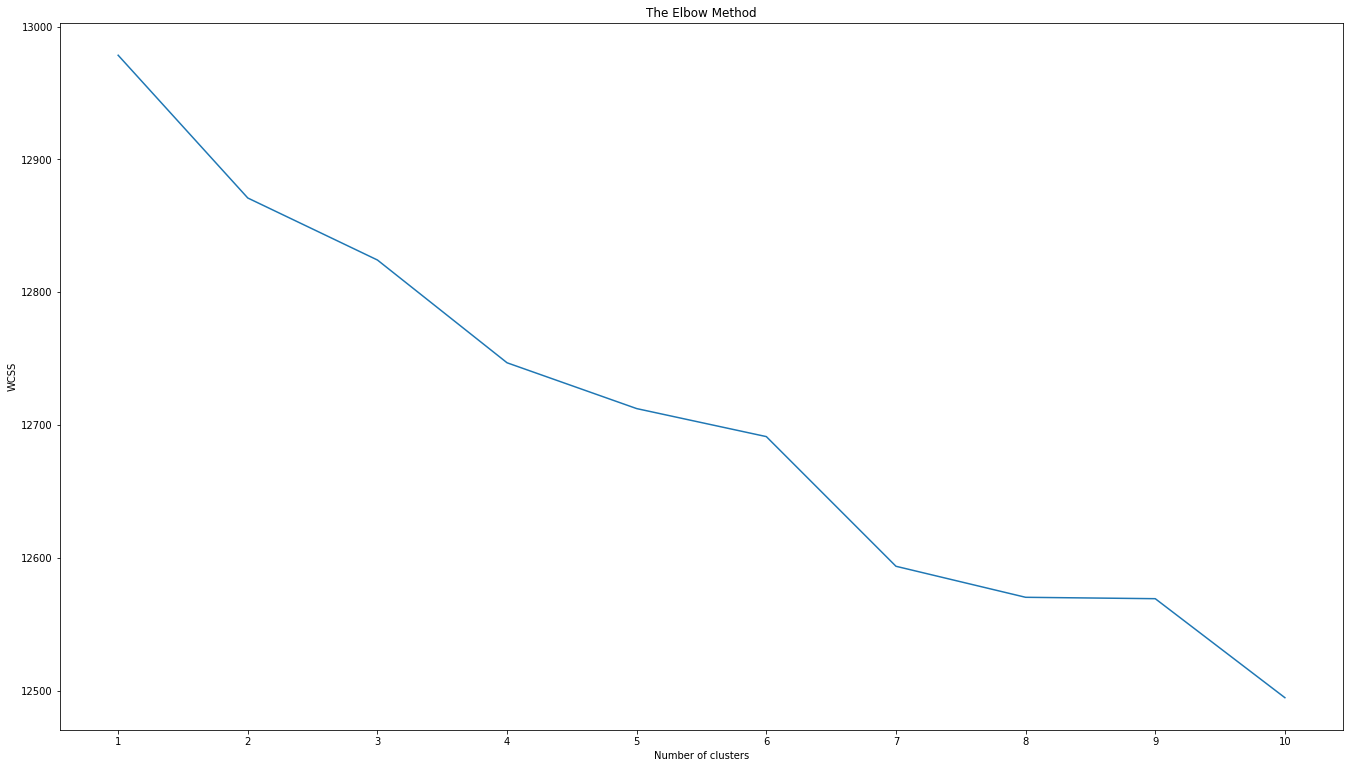

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (23,13)
plt.plot(range(1,11),wcss)
plt.title("The Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.xticks(range(1,11))
plt.show()

In [99]:
#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

In [146]:
kmeans = KMeans(n_clusters=7,random_state=42)

In [147]:
y_kmeans = kmeans.fit_predict(X)

In [168]:
set(list(y_kmeans))

{0, 1, 2, 3, 4, 5, 6}

In [157]:
author_dict = {}
for i,author in zip(range(len(author_list)),author_list):
    author_dict[i] = author

In [158]:
author_dict

{0: 'Anderson',
 1: 'Ashwell',
 2: 'Beck',
 3: 'Buckner',
 4: 'Carleton',
 5: 'Constant',
 6: 'Derleth',
 7: 'Duncan',
 8: 'Smith',
 9: 'Wylie'}

In [161]:
clusters = {}
n = 0
for item in y_kmeans:
    if item in clusters:
        clusters[item].append(author_dict[n])
    else:
        clusters[item] = [author_dict[n]]
    n +=1
    if n == 10:
        break

In [162]:
for item in clusters:
    print("Cluster ", item)
    for i in clusters[item]:
        print(i)

Cluster  4
Anderson
Ashwell
Beck
Buckner
Carleton
Constant
Derleth
Duncan
Smith
Wylie


In [109]:
def ClusterIndicesNumpy(clustNum,labels_array):
    return np.where(labels_array == clustNum)[0]

In [194]:
clusters = {}
for cluster in range(7):
    if cluster not in clusters:
        clusters[cluster] = ClusterIndicesNumpy(cluster,kmeans.labels_)

In [195]:
clusters

{0: array([ 6501,  6509,  6526,  6557,  6620,  6625,  6644,  6649,  6658,
         6664,  6665,  6680,  6739,  6744,  6762,  6772,  6775,  6785,
         6799,  6814,  6819,  6826,  6832,  6834,  6839,  6841,  6845,
         6846,  6850,  6851,  6865,  6870,  6879,  6884,  6888,  6890,
         6895,  6898,  6905,  6908,  6910,  6915,  6918,  6919,  6925,
         6926,  6928,  6932,  6936,  6948,  6957,  6959,  6962,  6970,
         6971,  6976,  6980,  6986,  6994,  7001,  7005,  7026,  7044,
         7059,  7068,  7072,  7074,  7082,  7096,  7099,  7111,  7126,
         7136,  7166,  7167,  7172,  7181,  7208,  7226,  7232,  7238,
         7239,  7258,  7263,  7275,  7288,  7294,  7296,  7299,  7301,
         7306,  7311,  7321,  7334,  7338,  7340,  7346,  7351,  7354,
         7358,  7364,  7381,  7394,  7406,  7408,  7432,  7436,  7437,
         7443,  7446,  7454,  7456,  7461,  7467,  7475,  7489,  7494,
         7499,  7509,  7552,  7555,  7566,  7572,  7573,  7579,  7588,
   

In [197]:
for k,v in clusters.items():
    print("Cluster {}".format(k))
    for i in v:
        if text_df.at[i,"Author"] in cluster_auth:
            cluster_auth[ktext_df.at[i,"Author"]] += 1
        else:
            cluster_auth[text_df.at[i,"Author"]] = 1

In [198]:
cluster_auth

{'Wylie': 7828,
 'Anderson': 1266,
 'Ashwell': 1324,
 'Beck': 153,
 'Buckner': 543,
 'Carleton': 110,
 'Constant': 375,
 'Derleth': 391,
 'Duncan': 1039,
 'Smith': 805}

In [185]:
text_df.at[cluster_0[0],"Author"]

'Wylie'

In [149]:
from sklearn.decomposition import PCA

X_pca = PCA(2).fit_transform(X)
#X_lsa = lsa.fit_transform(X)

In [148]:
from sklearn.manifold import TSNE

lsa_embed = TSNE(n_components=2,perplexity=40,verbose=2).fit_transform(X_lsa)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13834 samples in 0.915s...
[t-SNE] Computed neighbors for 13834 samples in 526.781s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13834
[t-SNE] Computed conditional probabilities for sample 2000 / 13834
[t-SNE] Computed conditional probabilities for sample 3000 / 13834
[t-SNE] Computed conditional probabilities for sample 4000 / 13834
[t-SNE] Computed conditional probabilities for sample 5000 / 13834
[t-SNE] Computed conditional probabilities for sample 6000 / 13834
[t-SNE] Computed conditional probabilities for sample 7000 / 13834
[t-SNE] Computed conditional probabilities for sample 8000 / 13834
[t-SNE] Computed conditional probabilities for sample 9000 / 13834
[t-SNE] Computed conditional probabilities for sample 10000 / 13834
[t-SNE] Computed conditional probabilities for sample 11000 / 13834
[t-SNE] Computed conditional probabilities for sample 12000 / 13834
[t-SNE] Computed conditional probabilities for 

No handles with labels found to put in legend.


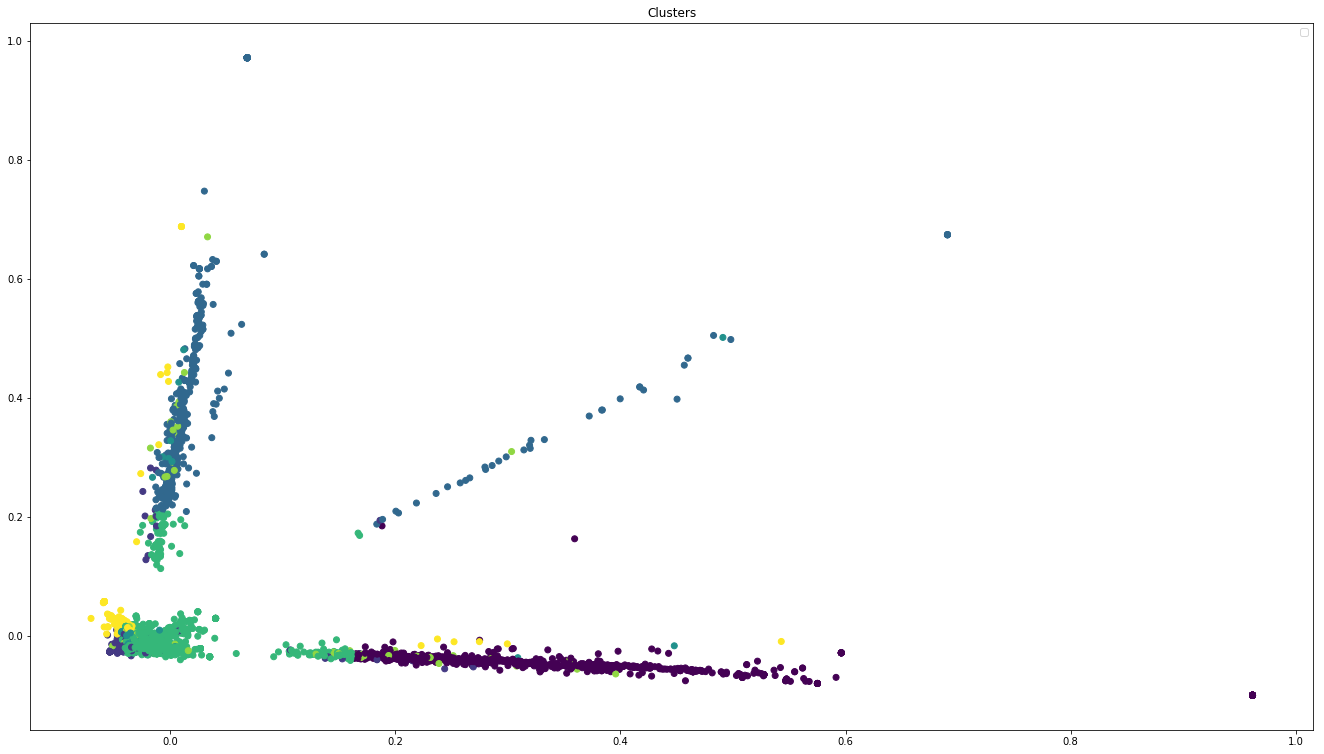

In [150]:
# visualizing the clusters (only for 2-dimensional clustering, reduce 2+ dimensions using PCA)

plt.rcParams['figure.figsize'] = (23,13)
plt.scatter(X_pca[:,0],X_pca[:,1],c=y_kmeans)
plt.title("Clusters")
plt.legend()
plt.show()